# Assignment 3: Predicting Mapping Penalties with From-Scratch ANN
**Due:** June 5, 2025, 11:59 PM

**Author:** Tony Liang

**Student Number:** 20990204

In this assignment, a feed-forward artificial neural network (ANN) is implemented from scratch to predict the penalty score of a mapping between tasks and employees.

In this notebook we will:
1. Import required libraries
2. Load the 100 mappings dataset and preprocess into 110-dim vectors  
3. Define the ANN architectures and implement forward, backward, updates by hand  
4. Train via mini-batch SGD over grid of hyperparameters  
5. Produce the eight required comparison plots  
6. Export results for report submission  

## 1. Assignment Imports

The assignment mapping dataset is loaded by cloning my personal Github repo, creating a copy within Google Colab.  

Library imports includes Numpy, Pandas, Pyplot and Time for numeric ops, data I/O, plotting and timing operations. The synthetic task and employee dataset is also initialised for constructing the input vectors.

In [ ]:
try:
  if loaded:
    print("Data loaded!")
except:
  !git clone https://github.com/tonyzrl/ANN_Assignment
loaded = True

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from google.colab import files

# Set global seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Task data: ID, Estimated Time, Difficulty, Deadline, Skill Required
tasks = [{"id": "T1", "estimated_time": 4, "difficulty": 3, "deadline": 8, "skill_required": "A"},
        {"id": "T2", "estimated_time": 6, "difficulty": 5, "deadline": 12, "skill_required": "B"},
        {"id": "T3", "estimated_time": 2, "difficulty": 2, "deadline": 6, "skill_required": "A"},
        {"id": "T4", "estimated_time": 5, "difficulty": 4, "deadline": 10, "skill_required": "C"},
        {"id": "T5", "estimated_time": 3, "difficulty": 1, "deadline": 7, "skill_required": "A"},
        {"id": "T6", "estimated_time": 8, "difficulty": 6, "deadline": 15, "skill_required": "B"},
        {"id": "T7", "estimated_time": 4, "difficulty": 3, "deadline": 9, "skill_required": "C"},
        {"id": "T8", "estimated_time": 7, "difficulty": 5, "deadline": 14, "skill_required": "B"},
        {"id": "T9", "estimated_time": 2, "difficulty": 2, "deadline": 5, "skill_required": "A"},
        {"id": "T10", "estimated_time": 6, "difficulty": 4, "deadline": 11, "skill_required": "C"},]

# Employee data: ID, Available hours, Skill level, Skills
employees = [{"id": "E1", "hours_avail": 10, "skill_level": 4, "skills": ["A", "C"]},
            {"id": "E2", "hours_avail": 12, "skill_level": 6, "skills": ["A", "B", "C"]},
            {"id": "E3", "hours_avail": 8, "skill_level": 3, "skills": ["A"]},
            {"id": "E4", "hours_avail": 15, "skill_level": 7, "skills": ["B", "C"]},
            {"id": "E5", "hours_avail": 9, "skill_level": 5, "skills": ["A", "C"]}]

## 2. Data Loading & Preprocessing

Data preprocessing requires two functions. The *one_hot_encode* function helps to encode the task and employee skillset categorical features into a numeric vector that will be inserted into the inputs. For example:
*   skill_required 'A' will be represented as [ 1 , 0 , 0 ]
*   skills [ 'A' , 'C' ] will be represented as [ 1 , 0 , 1 ]

The function *construct_input_vector* builds our 110-dimensional input vector from a single row of assignment mappings from the CSV dataset. This includes finding the 6 task and 5 employee features from the synthetic data and encoding the categorical data using *one_hot_encode* to build the input array.

In [92]:
def one_hot_encode(skills):
    """
    One-hot encode a list of skills, e.g. ['A','C'] -> [1,0,1].
    """
    mapping = {'A': 0, 'B': 1, 'C': 2}
    vec = [0, 0, 0]
    for s in skills:
        vec[mapping[s]] = 1
    return vec

def construct_input_vector(mapping_row):
    """
    Construct 110-dim vector from task→employee assignments + penalty.
    """
    input_vector = []
    for idx, emp_id in enumerate(mapping_row[:10], start=1):
        task = next(t for t in tasks if t["id"] == f"T{idx}")
        emp = next(e for e in employees if e["id"] == emp_id)

        # Task features
        input_vector.extend([
            task["estimated_time"],
            task["difficulty"],
            task["deadline"]
        ] + one_hot_encode(task["skill_required"]))

        # Employee features
        input_vector.extend([
            emp["hours_avail"],
            emp["skill_level"],
        ] + one_hot_encode(emp["skills"]))

    return np.array(input_vector)

Next, data is loaded from the CSV file and preprocessed so that they are ready to be fed into the neural network. This includes splitting the mappings and penalties values, encoding the mapping assignments into the input array, and splitting it into training, validation and testing sets in a 70/15/15 proportion. Finally, the input datasets are transposed and are ready to be used for ANN training.

In [93]:
# Load data
data_df = pd.read_csv('/content/ANN_Assignment/data/task_assignment_data.csv')
data = data_df.values  # (N, 11): 10 assignments + 1 penalty

# Splitting assignments and penalties
assignments, penalties = [], []
for row in data:
    assignments.append(construct_input_vector(row))
    penalties.append(row[-1])

X = np.vstack(assignments)
y = np.array(penalties).reshape(-1, 1)

# Shuffle and split based on training, validation and testing
N = X.shape[0]
perm = np.random.permutation(N)
X_sh, y_sh = X[perm], y[perm]

X_train = X_sh[:70].T
y_train = y_sh[:70].T

X_val   = X_sh[70:85].T
y_val   = y_sh[70:85].T

X_test  = X_sh[85:].T
y_test  = y_sh[85:].T

## 3. Model Architecture

### Activation Functions

**Sigmoid**

The Sigmoid function is a common activation function used in Neural Networks, particularly for binary classification problems. It is represented by the following formula:

**\begin{equation}
\sigma(x) = \frac{1}{1+e^{-x}}
\end{equation}**

Where $x$ is the input to the function. The Sigmoid function maps any real-valued number to a value between 0 and 1, which can be interpreted as a probability.

The derivative of the Sigmoid function can be computed as:

\begin{equation}
\sigma'(x) = \sigma(x)(1-\sigma(x))
\end{equation}

---

**ReLU**

The Rectified Linear Unit (ReLU) is a simple, yet highly effective activation function commonly used in Neural Networks. It is defined as:

**\begin{equation}
ReLU(x) = max(0, x)
\end{equation}**

Where $x$ is the input to the function. ReLU sets all negative values of $x$ to zero, and leaves the positive values unchanged.

The derivative of the ReLU function can be computed as:

**\begin{equation}
ReLU'(x) =
\begin{cases}
1, & x > 0\\
0, & x \le 0,
\end{cases}
\end{equation}**

---

**Implementation of Activation Functions**

In our neural network architecture, we define 2 activation functions and their respective derivatives. Both *sigmoid* and *relu* computes and then returns the activation value $A$ and the cached pre-activation input $Z$.

Both backward functions *sigmoid_back* and *relu_back* imports the gradient $dA$ and the parameter cache to calculate the gradient with respect to $Z$ by implementing the derivatives of the activation functions.

In [94]:
def sigmoid(Z):
    """
    Implement the Sigmoid function.
    """
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def sigmoid_back(dA, cache):
    """
    Implement the backward propagation for a single sigmoid unit.
    """
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

def relu(Z):
    """
    Implement the ReLU function.
    """
    A = np.maximum(0,Z)
    cache = Z
    return A, cache

def relu_back(dA, cache):
    """
    Implement the backward propagation for a single ReLU unit.
    """
    Z = cache
    dZ = np.array(dA, copy=True)
    # When z <= 0, dz is equal to 0 as well.
    dZ[Z <= 0] = 0
    return dZ

### Neural Network Class


**Initialise Parameters**

We start by initialising the weights and biases of the model. For each layer $l$ in the network, we initialise $W^{[l]}$ to be a matrix with dimensions $(n^{[l]}, n^{[l-1]})$ with random values between 0 and 0.01, where $n^{[l]}$ is the number of neurons in the layer $l$ and $n^{[l-1]}$ is the number of neurons in the previous layer. We also initialise $b^{[l]}$ to be a vector with dimensions $(n^{[l]}, 1)$ with zeros.

---

**Forward Propagation**

In the forward pass, we propagate through the network calculating the output of every layer. For each hidden layer $l$ in the network, we calculate:

**\begin{equation}
Z^{[l]} = W^{[l]}.A^{[l-1]} +b^{[l]}
\end{equation}**

**\begin{equation}
A^{[l]} = g(Z^{[l]})
\end{equation}**

Where $A^{[0]} = X$ is the input to the network and $g(.)$ is the activation function used.

For the final output layer, we calculate the linear output $Z^{[l]}$, which represents the predicted value $Y$.

---

**Compute Cost**

We calculate the cost function to determine how well the neural network is making predictions. For this problem, we employee the Mean Squared Error (MSE) function to measure our network performance. The cost function can be computed as:

**\begin{equation}
L = \frac{1}{N} \sum_{i=1}^{N} (y_{i} - \hat{y}_{i})^2
\end{equation}**

Where $\hat{y}_{i}$ is the predicted output of the network for the $i$-th input example and $y_{i}$ is the true output for the $i$-th input example.

---

**Backpropagation**

In the backward pass, we compute the derivatives of the loss function with respect to the parameters of the network using the chain rule of differentiation. Specifically, we calculate the derivatives of the cost function with respect to $Z^{[l]}$, which can then be used to calculate the derivatives of the cost function with respect to $W^{[l]}$ and $b^{[l]}$.

---

**Updating Parameters**

We update the parameters of the network using gradient descent, which tries to reduce the cost by adjusting the parameters in the opposite direction of the gradient. The gradient descent rule is, for each layer $l$ in the network:

**\begin{equation}
W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}
\end{equation}**

**\begin{equation}
b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}
\end{equation}**

Where $\alpha$ is the learning rate and $dW^{[l]}$ and $db^{[l]}$ are the derivatives of the cost function $dL$ with respect to $W^{[l]}$ and $b^{[l]}$, respectively.

In [95]:
class NeuralNetwork:
    def __init__(self, layer_dims=[110, 256, 1], learning_rate=1e-3, activation='relu'):
        """
        layer_dims: list of layer sizes, e.g [110,256,1] or [110,128,128,1]
        learning_rate: step size for gradient descent
        activation: 'relu' or 'sigmoid' for hidden layers
        """
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate

        # pick activation & its derivative
        if activation.lower() == 'relu':
            self.activation = relu
            self.activation_back = relu_back
        else:
            self.activation = sigmoid
            self.activation_back = sigmoid_back

        # number of layers (excluding input)
        self.L = len(layer_dims) - 1

        # initialise random values for weights and biases
        for l in range(1, self.L + 1):
            n_in  = layer_dims[l-1]
            n_out = layer_dims[l]
            setattr(self, f'W{l}', np.random.randn(n_out, n_in) * 0.01)
            setattr(self, f'b{l}', np.zeros((n_out, 1)))

    def forward(self, X):
        """
        Performs a full forward pass.
        Returns:
          Zl: (1, m) predictions
          caches: list of ((A,W,b), Z) tuples
        """
        caches = []
        A = X

        # hidden layers
        for l in range(1, self.L):
            W = getattr(self, f'W{l}')
            b = getattr(self, f'b{l}')
            Z = W @ A + b
            # Cache (A_prev_for_next_layer, W, b) and Z
            caches.append(((A, W, b), Z))
            # Compute activation output
            A, _ = self.activation(Z)

        # output layer (linear)
        Wl = getattr(self, f'W{self.L}')
        bl = getattr(self, f'b{self.L}')
        Zl = Wl @ A + bl

        # Cache (A for output layer, Wl, bl) and Zl
        caches.append(((A, Wl, bl), Zl))
        return Zl, caches

    def back_layer(self, dZ, cache):
        """
        Backprop for a single layer given dZ = dL/dZ_l.
        cache: ((A_prev, W, b), Z)
        Returns dA_prev, dW, db.
        """
        (A_prev, W, b), Z = cache
        m = A_prev.shape[1]
        dW = (1/m) * (dZ @ A_prev.T)
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = W.T @ dZ
        return dA_prev, dW, db

    def backward(self, Y_hat, Y, caches):
        """
        Performs backprop over the whole network.
        Returns a dict of grads {dW1, db1, …, dWL, dbL}.
        """
        grads = {}
        m = Y.shape[1]

        # dZ for MSE loss at output: d/dZ [ (1/m) ∑ (ZL - Y)^2 ] = 2*(ZL - Y)/m
        dZ = 2 * (Y_hat - Y) / m

        # **Output layer** gradients (Layer L)
        cacheL = caches[-1] # This is the cache for the last layer (output)
        dA_prev, dWl, dbl = self.back_layer(dZ, cacheL)
        grads[f'dW{self.L}'] = dWl
        grads[f'db{self.L}'] = dbl

        # **Hidden layers** (L-1 .. 1)
        # dA here is the gradient of the cost with respect to the activation output of layer L-1
        dA = dA_prev
        for l in reversed(range(1, self.L)): # Loop through hidden layers backwards
            # cache for the current layer 'l' from forward pass
            # This cache contains ((A_prev_to_layer_l, W_l, b_l), Z_l)
            cache_l = caches[l-1]

            # Get Z_l from cache
            Z = cache_l[1]

            # Convert dA_l (gradient wrt A_l) to dZ_l (gradient wrt Z_l)
            # A_l is the activation output of layer l.
            # dA was computed as the backprop output from layer l+1,
            # so it's the gradient wrt A_l.
            dZ = self.activation_back(dA, Z)

            # Get A_prev_to_layer_l from cache
            A_prev = cache_l[0][0]

            # Backprop through the linear part of layer l
            dA, dW, db = self.back_layer(dZ,((A_prev, cache_l[0][1], cache_l[0][2]), Z))
            grads[f'dW{l}'] = dW
            grads[f'db{l}'] = db
        return grads

    def update_parameters(self, grads):
        """
        Applies gradient descent: W -= lr * dW,  b -= lr * db.
        """
        for l in range(1, self.L+1):
            W = getattr(self, f'W{l}')
            b = getattr(self, f'b{l}')
            dW = grads[f'dW{l}']
            db = grads[f'db{l}']
            setattr(self, f'W{l}', W - self.learning_rate * dW)
            setattr(self, f'b{l}', b - self.learning_rate * db)

    def compute_cost(self, Y_true, Y_hat):
        """
        Mean Squared Error: (1/m) * sum((Y_true - Y_hat)^2)
        """
        return np.square(np.subtract(Y_true, Y_hat)).mean()

## 4. Training Loop & Hyperparameter Grid Search

In this section, we perform an exhaustive grid search over the three key hyperparameters:
*   Learning rate (0.01, 0.001, 0.0001)
*   Batch size (8, 16, 32)
*   Activation function (Sigmoid & ReLU)
*   Epochs (100, 150, 200)

For each of our two network architectures. For each combination, we instantiate a fresh model, train it for a set number of epochs using mini‐batch gradient descent (shuffling the training set each epoch and recording both training and validation losses plus epoch timing), and then evaluate its performance on the remaining test set. All results including the hyperparameter settings, loss histories, epoch times, and final test loss are stored in a list of dictionaries, which in the end, we scan to identify and report the combination that achieves the lowest test loss for Model A and Model B.



In [96]:
def grid_search_training(layer_dims):
    # Hyper-parameter grid
    learning_rates = [0.01, 0.001, 0.0001]
    batch_sizes    = [8, 16, 32]
    activations    = ['sigmoid', 'relu']
    epochs    = [100, 150, 200]

    results = []

    for lr in learning_rates:
        for bs in batch_sizes:
            for act in activations:
                for num_epochs in epochs:
                    # fresh model for each combo
                    model = NeuralNetwork(layer_dims, learning_rate=lr, activation=act)
                    train_losses = []
                    val_losses   = []
                    epoch_times  = []

                    # run for this many epochs
                    for epoch in range(num_epochs):
                        t0 = time.time()

                        # shuffle…
                        perm = np.random.permutation(X_train.shape[1])
                        X_sh, y_sh = X_train[:, perm], y_train[:, perm]

                        # mini-batch SGD
                        for i in range(0, X_sh.shape[1], bs):
                            xb = X_sh[:, i:i+bs]
                            yb = y_sh[:, i:i+bs]
                            # forward -> backward -> update
                            y_hat, caches = model.forward(xb)
                            grads = model.backward(y_hat, yb, caches)
                            model.update_parameters(grads)

                        # record losses and timing
                        y_hat_tr, _ = model.forward(X_train)
                        train_losses.append(model.compute_cost(y_hat_tr, y_train))

                        y_hat_val, _ = model.forward(X_val)
                        val_losses.append(model.compute_cost(y_hat_val, y_val))

                        epoch_times.append(time.time() - t0)

                    # final test evaluation
                    y_hat_test, _ = model.forward(X_test)
                    test_loss = model.compute_cost(y_test, y_hat_test)

                    results.append({
                        'layer_dims':   layer_dims,
                        'learning_rate': lr,
                        'batch_size':   bs,
                        'activation':   act,
                        'num_epochs':   num_epochs,
                        'train_losses': train_losses,
                        'val_losses':   val_losses,
                        'epoch_times':  epoch_times,
                        'test_loss':    test_loss
                    })

    return results


# Define two model architectures
modelA = [110, 256, 1]
modelB = [110, 128, 128, 1]

# Running training and grid‐search
resultsA = grid_search_training(modelA)
resultsB = grid_search_training(modelB)

# Find the run with minimum test loss
bestA = min(resultsA, key=lambda r: r['test_loss'])
bestB = min(resultsB, key=lambda r: r['test_loss'])

print(f"Model A best test loss: {bestA['test_loss']:.4f} "
      f"(epochs={bestA['num_epochs']}, lr={bestA['learning_rate']}, "
      f"bs={bestA['batch_size']}, act={bestA['activation']})")

print(f"Model B best test loss: {bestB['test_loss']:.4f} "
      f"(epochs={bestB['num_epochs']}, lr={bestB['learning_rate']}, "
      f"bs={bestB['batch_size']}, act={bestB['activation']})")

Model A best test loss: 2.1761 (epochs=100, lr=0.01, bs=8, act=sigmoid)
Model B best test loss: 2.1578 (epochs=150, lr=0.01, bs=32, act=sigmoid)


## 5. Evaluation and Plots

### Epoch vs Loss (Train & Val)


In this section, we've defined a helper function that pulls out the training and validation loss curves for a given learning rate, batch size, and activation from our grid-search results, then plots those losses against epoch number. We call the function twice, once for Model A and once for Model B, showing how training and validation MSE evolve over the 100 epochs.

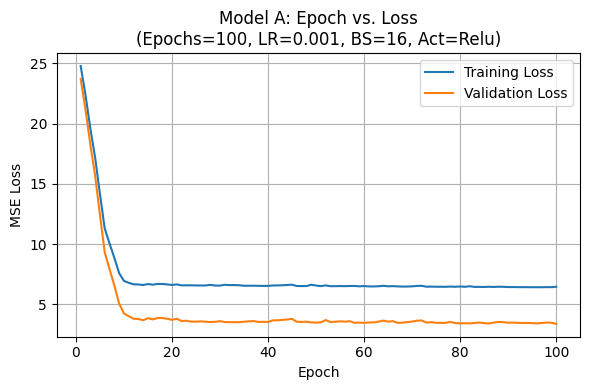

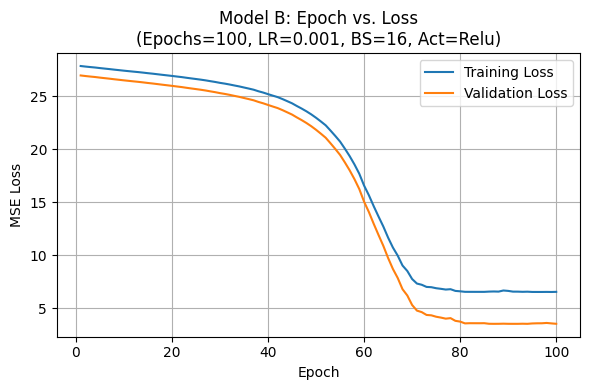

In [97]:
def plot_epoch_vs_loss(runs, model_label, learning_rate=0.001, batch_size=16,
                       activation='relu', num_epochs=100, out_file=None):
    # pick the run that matches all four hyper-params
    run = next(r for r in runs
               if r['learning_rate'] == learning_rate
               and r['batch_size'] == batch_size
               and r['activation'] == activation
               and r['num_epochs'] == num_epochs)

    train, val = run['train_losses'], run['val_losses']
    epochs = range(1, len(train) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label='Training Loss')
    plt.plot(epochs, val,   label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(
        f"{model_label}: Epoch vs. Loss\n"
        f"(Epochs={num_epochs}, LR={learning_rate}, "
        f"BS={batch_size}, Act={activation.capitalize()})"
    )
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if out_file:
        plt.savefig(out_file)
    plt.show()

plot_epoch_vs_loss(resultsA, 'Model A', out_file='modelA_Epoch_vs_Loss.png')
plot_epoch_vs_loss(resultsB, 'Model B', out_file='modelB_Epoch_vs_Loss.png')

### Learning Rate vs Loss (Test)

In this section, we've defined a helper function that scans our grid-search results for a fixed batch size and activation, collects and sorts each run's (learning rate, test loss) pair, and then plots test-loss against learning rate on a log scale. We call the function twice, once for Model A and once for Model B to generate and save the corresponding LR vs. test-loss curves.

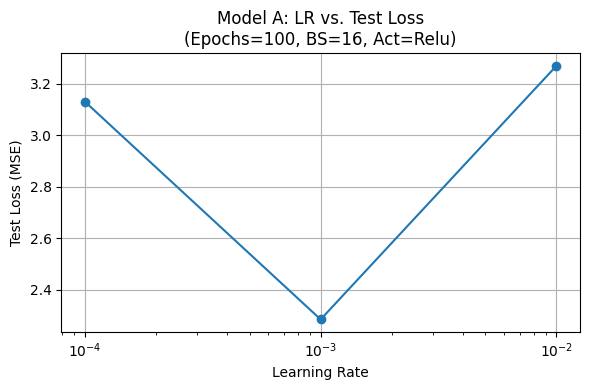

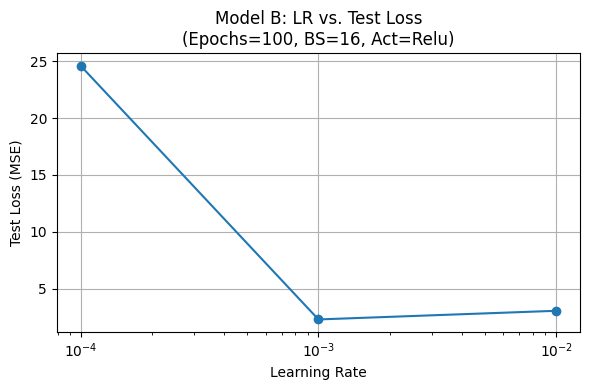

In [98]:
def plot_lr_vs_test_loss(runs, model_label, batch_size=16, activation='relu',
                         num_epochs=100, out_file=None):
    # collect and sort (lr, loss) pairs for the specified hyper-params
    lr_loss = [
        (r['learning_rate'], r['test_loss'])
        for r in runs
        if r['batch_size'] == batch_size
        and r['activation'] == activation
        and r['num_epochs'] == num_epochs]

    lrs, losses = zip(*sorted(lr_loss, key=lambda x: x[0]))

    plt.figure(figsize=(6,4))
    plt.plot(lrs, losses, marker='o')
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Test Loss (MSE)')
    plt.title(
        f"{model_label}: LR vs. Test Loss\n"
        f"(Epochs={num_epochs}, BS={batch_size}, Act={activation.capitalize()})"
    )
    plt.grid(True)
    plt.tight_layout()

    if out_file:
        plt.savefig(out_file)
    plt.show()

plot_lr_vs_test_loss(resultsA, 'Model A', out_file='modelA_LR_vs_TestLoss.png')
plot_lr_vs_test_loss(resultsB, 'Model B', out_file='modelB_LR_vs_TestLoss.png')

### Activation Function vs Loss (Train & Val)

In this section, we've defined a helper function, that for each activation function (ReLU vs. Sigmoid) pulls out that run’s final‐epoch training and validation losses, and then displays them as side‐by‐side bars so we can directly compare how each activations performed. At the end of the cell we call it once for Model A and once for Model B, generating two plots that visualise the train & val MSE for ReLU vs. Sigmoid.

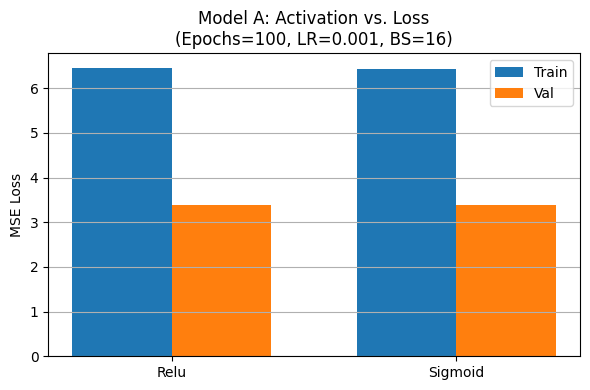

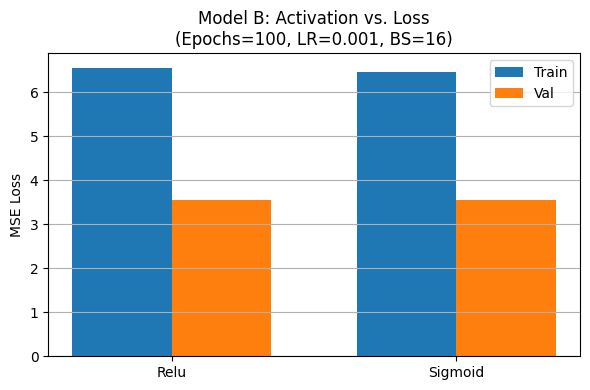

In [99]:
def plot_activation_vs_loss(runs, model_label, learning_rate=0.001, batch_size=16,
                            activations=('relu', 'sigmoid'), num_epochs=100,
                            out_file=None):
    # collect last‐epoch train & val losses for each activation at the specified epoch count
    train_losses = []
    val_losses   = []
    for act in activations:
        run = next(r for r in runs
                   if r['activation'] == act
                   and r['learning_rate'] == learning_rate
                   and r['batch_size'] == batch_size
                   and r['num_epochs'] == num_epochs)

        train_losses.append(run['train_losses'][-1])
        val_losses.append(  run['val_losses'][-1])

    x = np.arange(len(activations))
    width = 0.35

    plt.figure(figsize=(6,4))
    plt.bar(x - width/2, train_losses, width, label='Train')
    plt.bar(x + width/2, val_losses,   width, label='Val')
    plt.xticks(x, [a.capitalize() for a in activations])
    plt.title(
        f"{model_label}: Activation vs. Loss\n"
        f"(Epochs={num_epochs}, LR={learning_rate}, BS={batch_size})"
    )
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()

    if out_file:
        plt.savefig(out_file)
    plt.show()

plot_activation_vs_loss(resultsA, 'Model A', out_file='modelA_AF_vs_Loss.png')
plot_activation_vs_loss(resultsB, 'Model B', out_file='modelB_AF_vs_Loss.png')

### Batch Size vs Epoch Time

In this section, we defined a helper function, which for a fixed learning rate and activation, grabs each run’s average epoch timing across batch sizes (8, 16, 32) from our grid‐search results and plots batch size versus average epoch time. At the end we call it twice, once for Model A and once for Model B automatically producing two plots that show how increasing the batch size impacts training speed.

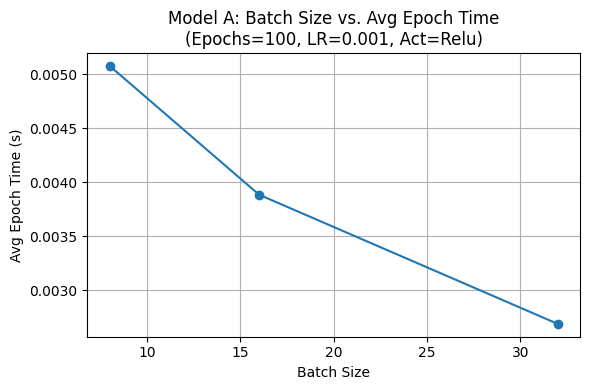

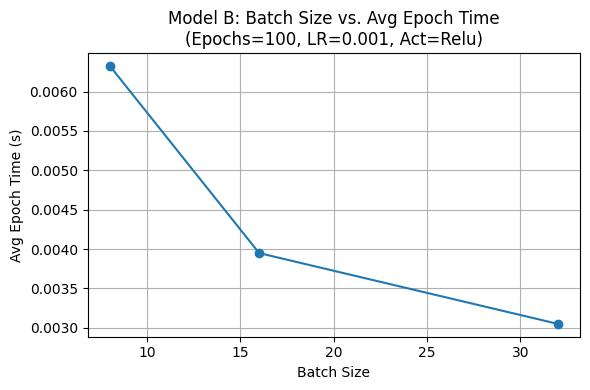

In [100]:
def plot_bs_vs_epoch_time(runs, model_label, learning_rate=0.001, activation='relu',
                          batch_sizes=(8, 16, 32), num_epochs=100, out_file=None):
    avg_times = []
    for bs in batch_sizes:
        run = next(r for r in runs
                   if r['batch_size'] == bs
                   and r['learning_rate'] == learning_rate
                   and r['activation'] == activation
                   and r['num_epochs'] == num_epochs)
        avg_times.append(np.mean(run['epoch_times']))

    plt.figure(figsize=(6,4))
    plt.plot(batch_sizes, avg_times, marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Avg Epoch Time (s)')
    plt.title(
        f"{model_label}: Batch Size vs. Avg Epoch Time\n"
        f"(Epochs={num_epochs}, LR={learning_rate}, Act={activation.capitalize()})"
    )
    plt.grid(True)
    plt.tight_layout()

    if out_file:
        plt.savefig(out_file)
    plt.show()

plot_bs_vs_epoch_time(runs=resultsA, model_label='Model A', out_file='modelA_BS_vs_EpochTime.png')
plot_bs_vs_epoch_time(runs=resultsB, model_label='Model B', out_file='modelB_BS_vs_EpochTime.png')

## 6. Exporting Plots

Run to save every plot locally

In [ ]:
# Downloading figures locally

download = input("Download all figures now? (y/n): ").strip().lower()
if download in ('y', 'yes'):
    files.download('modelA_Epoch_vs_Loss.png')
    files.download('modelB_Epoch_vs_Loss.png')
    files.download('modelA_LR_vs_TestLoss.png')
    files.download('modelB_LR_vs_TestLoss.png')
    files.download('modelA_AF_vs_Loss.png')
    files.download('modelB_AF_vs_Loss.png')
    files.download('modelA_BS_vs_EpochTime.png')
    files.download('modelB_BS_vs_EpochTime.png')
else:
    print("Skipping downloads.")